In [63]:
pip install pyspark


Note: you may need to restart the kernel to use updated packages.


In [64]:
from pyspark.sql import SparkSession
# Step 1: Initialize Spark Session
spark = SparkSession.builder \
    .appName("Airline_Passenger_Satisfaction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Step 2: Load the CSV Files
df_train_raw = spark.read.csv("hdfs://namenode:9000/train.csv", header=True, inferSchema=True)
df_test_raw = spark.read.csv("hdfs://namenode:9000/test.csv", header=True, inferSchema=True)
df_train_raw.printSchema()
df_test_raw.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable = true)
 |-- Checkin service: integer (nullable = true)
 |-- Inflight service: integer (nullable = true)
 |-- Cleanline

In [65]:
# Check if the schemas are the same
if df_train_raw.schema == df_test_raw.schema:
    print("The schemas are the same.")
else:
    print("The schemas are different.")


The schemas are the same.


In [66]:
df_train_raw.show(5)


+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|_c0|    id|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+-

In [67]:
df_train_raw = df_train_raw.drop('_c0', 'id')
df_test_raw = df_test_raw.drop('_c0', 'id')

df_train_raw.show(5)
df_test_raw.show(5)


+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+--------------------+
|Gender|    Customer Type|Age| Type of Travel|   Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|        satisfaction|
+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+---

In [68]:
# Count Total Rows and Rows with Null Values
from functools import reduce
from pyspark.sql.functions import col, count
def count_null_rows(df):
    return df.filter(reduce(lambda x, y: x | y, (col(c).isNull() for c in df.columns))).count()

total_train_rows = df_train_raw.count()
total_test_rows = df_test_raw.count()
null_train_rows = count_null_rows(df_train_raw)
null_test_rows = count_null_rows(df_test_raw)

# Calculate Null Rate
null_rate_train = (null_train_rows / total_train_rows) * 100
null_rate_test = (null_test_rows / total_test_rows) * 100

# Display Results
print(f"Total rows in train.csv: {total_train_rows}")
print(f"Rows with nulls in train.csv: {null_train_rows} ({null_rate_train:.2f}%)")
print(f"Total rows in test.csv: {total_test_rows}")
print(f"Rows with nulls in test.csv: {null_test_rows} ({null_rate_test:.2f}%)")

Total rows in train.csv: 103904
Rows with nulls in train.csv: 310 (0.30%)
Total rows in test.csv: 25976
Rows with nulls in test.csv: 83 (0.32%)


In [69]:
# Remove Rows with Null Values
df_train_cleaned = df_train_raw.na.drop()
df_test_cleaned = df_test_raw.na.drop()

# Verify No Nulls Remain After Removal
null_train_cleaned_rows = count_null_rows(df_train_cleaned)
null_test_cleaned_rows = count_null_rows(df_test_cleaned)

# Display Results After Removal
print("\nAfter removing rows with nulls:")
print(f"Total rows in cleaned train.csv: {df_train_cleaned.count()}")
print(f"Rows with nulls in cleaned train.csv: {null_train_cleaned_rows}")
print(f"Total rows in cleaned test.csv: {df_test_cleaned.count()}")
print(f"Rows with nulls in cleaned test.csv: {null_test_cleaned_rows}")
df_train_cleaned.printSchema()
df_test_cleaned.printSchema()


After removing rows with nulls:
Total rows in cleaned train.csv: 103594
Rows with nulls in cleaned train.csv: 0
Total rows in cleaned test.csv: 25893
Rows with nulls in cleaned test.csv: 0
root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = true)
 |-- Leg room service: integer (nullable = true)
 |-- Baggage handling: integer (nullable 

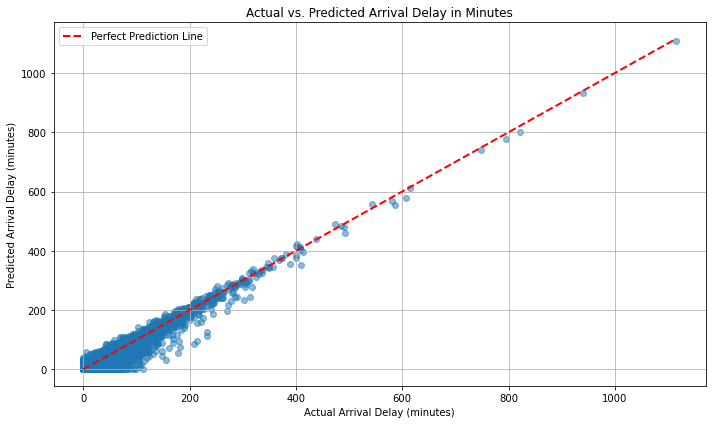

In [70]:
# Task1: linear regression task
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import pandas as pd

# Select relevant features for regression
regression_features = [
    'Flight Distance', 'Departure Delay in Minutes', 'Online boarding',
    'Seat comfort', 'Baggage handling','Checkin service'
]

# Assemble the features into a single vector
assembler_regression = VectorAssembler(inputCols=regression_features, outputCol="features")

# Prepare training data
df_train_regression = assembler_regression.transform(df_train_cleaned).select("features", "Arrival Delay in Minutes")

# Prepare testing data
df_test_regression = assembler_regression.transform(df_test_cleaned).select("features", "Arrival Delay in Minutes")


# Fit Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="Arrival Delay in Minutes")

# Train the model on the training data
lr_model = lr.fit(df_train_regression)

# Make predictions on the test data
lr_predictions = lr_model.transform(df_test_regression)

# Convert predictions to Pandas DataFrame for visualization
predictions_df = lr_predictions.select("Arrival Delay in Minutes", "prediction").toPandas()

# Visualize the Results
plt.figure(figsize=(10, 6))

# Scatter plot of actual vs. predicted values
plt.scatter(predictions_df["Arrival Delay in Minutes"], predictions_df["prediction"], alpha=0.5)
plt.plot([0, predictions_df["Arrival Delay in Minutes"].max()], [0, predictions_df["Arrival Delay in Minutes"].max()],
         color='red', linestyle='--', linewidth=2, label='Perfect Prediction Line')

plt.xlabel("Actual Arrival Delay (minutes)")
plt.ylabel("Predicted Arrival Delay (minutes)")
plt.title("Actual vs. Predicted Arrival Delay in Minutes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [71]:
# Calculate RMSE using RegressionEvaluator
evaluator_regression = RegressionEvaluator(
    labelCol="Arrival Delay in Minutes", 
    predictionCol="prediction", 
    metricName="rmse"
)

rmse = evaluator_regression.evaluate(lr_predictions)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Root Mean Squared Error (RMSE): 9.91


In [73]:
from pyspark.ml.feature import StringIndexer

# Encoding Categorical Variables
categorical_cols = [field for (field, dtype) in df_train_cleaned.dtypes if dtype == "string" and field != 'satisfaction']

# Apply StringIndexer consistently
for col in categorical_cols:
    index_col = col + "_index"
    # Check if the index column already exists
    if index_col not in df_train_cleaned.columns:
        indexer = StringIndexer(inputCol=col, outputCol=index_col)
        model = indexer.fit(df_train_cleaned)  # Fit only on the training data
        df_train_cleaned = model.transform(df_train_cleaned)  # Transform the training data
        df_test_cleaned = model.transform(df_test_cleaned)    # Transform the test data with the same model

# After encoding, the resulting DataFrames are 'df_train_encoded' and 'df_test_encoded'
df_train_encoded = df_train_cleaned
df_test_encoded = df_test_cleaned

# Display some rows to verify
df_train_encoded.select(*[col + "_index" for col in categorical_cols]).show(5)
df_test_encoded.show(5)

+------------+-------------------+--------------------+-----------+
|Gender_index|Customer Type_index|Type of Travel_index|Class_index|
+------------+-------------------+--------------------+-----------+
|         1.0|                0.0|                 1.0|        2.0|
|         1.0|                1.0|                 0.0|        0.0|
|         0.0|                0.0|                 0.0|        0.0|
|         0.0|                0.0|                 0.0|        0.0|
|         1.0|                0.0|                 0.0|        0.0|
+------------+-------------------+--------------------+-----------+
only showing top 5 rows

+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+---------

In [74]:
from pyspark.ml.feature import VectorAssembler

# Assemble Features into a Single Vector

# Get numerical columns, excluding the target column
numerical_cols = [field for (field, dtype) in df_train_encoded.dtypes if dtype in ['int', 'double']]

# Include indexed categorical columns
feature_cols = [col + "_index" if col in categorical_cols else col for col in numerical_cols]

# Initialize VectorAssembler
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform training and test data
df_train_assembled = assembler.transform(df_train_encoded)
df_test_assembled = assembler.transform(df_test_encoded)

# Display the assembled DataFrames
df_train_assembled.select("features", "satisfaction").show(5, truncate=False)
df_test_assembled.select("features").show(5, truncate=False)
df_train_assembled.printSchema()


+----------------------------------------------------------------------------------------------+-----------------------+
|features                                                                                      |satisfaction           |
+----------------------------------------------------------------------------------------------+-----------------------+
|[13.0,460.0,3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,25.0,18.0,1.0,0.0,1.0,2.0]|neutral or dissatisfied|
|[25.0,235.0,3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0,6.0,1.0,1.0,0.0,0.0]  |neutral or dissatisfied|
|[26.0,1142.0,2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0] |satisfied              |
|[25.0,562.0,2.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,2.0,5.0,3.0,1.0,4.0,2.0,11.0,9.0,0.0,0.0,0.0,0.0] |neutral or dissatisfied|
|[61.0,214.0,3.0,3.0,3.0,3.0,4.0,5.0,5.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0]  |satisfied              |
+-------------------------------

In [75]:
from pyspark.ml.feature import StandardScaler

# Step 8: Feature Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

# Fit the scaler on the training data only
scaler_model = scaler.fit(df_train_assembled)

# Transform both training and test data
df_train_scaled = scaler_model.transform(df_train_assembled)
df_test_scaled = scaler_model.transform(df_test_assembled)

# Display some rows to verify
df_train_scaled.select("scaled_features", "satisfaction").show(5, truncate=False)
df_test_scaled.select("scaled_features").show(5, truncate=False)
df_train_scaled.printSchema()

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+
|scaled_features                                                                                                                                                                                                                                                                                                                                                                                                                                          |satisfaction           |
+---------------------------------------------------------------

In [76]:
from pyspark.ml.stat import Summarizer

# Calculate mean and variance for scaled features
scaled_summary = df_train_scaled.select(
    Summarizer.mean(df_train_scaled["scaled_features"]).alias("mean"),
    Summarizer.variance(df_train_scaled["scaled_features"]).alias("variance")
).collect()[0]

mean_vector = scaled_summary["mean"]
variance_vector = scaled_summary["variance"]

# Display the results
print(f"Mean of scaled features: {mean_vector}")
print(f"Variance of scaled features: {variance_vector}")


Mean of scaled features: [2.1596927805150878e-14,-4.7661527502462775e-15,5.686423554251974e-15,9.814089645121538e-15,4.37589417826012e-15,7.406401880682978e-15,5.5571866552917015e-15,2.7968079241436072e-15,-3.3285006695304986e-15,-7.388837805488713e-16,4.412269161147009e-15,6.94626647868013e-15,5.676448894265107e-15,-4.532398761858403e-15,-1.0442601644511385e-14,1.0321604682062002e-15,-5.670377362099188e-16,1.0495077029659683e-16,6.331740687315346e-17,3.252606517456513e-17,-3.165870343657673e-17,-2.2371156576522777e-15]
Variance of scaled features: [1.000000000000001,1.0000000000000007,0.9999999999999983,1.0,0.9999999999999997,1.000000000000002,1.0000000000000029,1.00000000000001,1.0000000000000087,0.9999999999999942,0.9999999999999946,0.999999999999998,1.000000000000002,0.9999999999999994,1.0,1.0000000000000013,1.000000000000006,0.9999999999999931,1.000000000000002,1.0000000000000007,1.0000000000000029,0.9999999999999956]


In [77]:
from pyspark.ml.feature import StringIndexer

# Check and drop 'satisfaction_index' if it exists
if 'satisfaction_index' in df_train_scaled.columns:
    df_train_scaled = df_train_scaled.drop('satisfaction_index')
if 'satisfaction_index' in df_test_scaled.columns:
    df_test_scaled = df_test_scaled.drop('satisfaction_index')

# Fit StringIndexer on the training data
indexer = StringIndexer(inputCol='satisfaction', outputCol='satisfaction_index')
indexer_model = indexer.fit(df_train_scaled)

# Transform both training and test datasets using the same indexer model
df_train_scaled = indexer_model.transform(df_train_scaled)
df_test_scaled = indexer_model.transform(df_test_scaled)

# Show a few rows of the transformed training DataFrame
df_train_scaled.select('satisfaction', 'satisfaction_index').show(5, truncate=False)

# Check if 'satisfaction_index' is binary
distinct_values = df_train_scaled.select('satisfaction_index').distinct().count()
if distinct_values == 2:
    print("The satisfaction_index column is binary.")
else:
    print(f"The satisfaction_index column has {distinct_values} distinct values.")
df_train_scaled.printSchema()
df_test_scaled.printSchema()

+-----------------------+------------------+
|satisfaction           |satisfaction_index|
+-----------------------+------------------+
|neutral or dissatisfied|0.0               |
|neutral or dissatisfied|0.0               |
|satisfied              |1.0               |
|neutral or dissatisfied|0.0               |
|satisfied              |1.0               |
+-----------------------+------------------+
only showing top 5 rows

The satisfaction_index column is binary.
root
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- O

SVM ROC AUC: 0.9257
Confusion Matrix:
[[13222  1306]
 [ 1985  9380]]


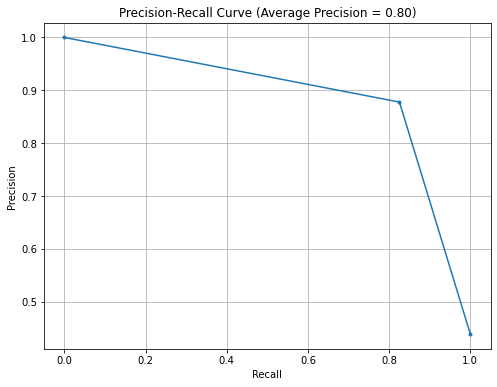

In [78]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# Define and Train SVM Model
svm = LinearSVC(labelCol='satisfaction_index', featuresCol='scaled_features', maxIter=10)

# Train the SVM model on the scaled training data
svm_model = svm.fit(df_train_scaled)

# Make predictions with the SVM model on the test data
svm_predictions = svm_model.transform(df_test_scaled)

# Step 5: Evaluate SVM Model
evaluator = BinaryClassificationEvaluator(labelCol='satisfaction_index', metricName='areaUnderROC')
svm_auc = evaluator.evaluate(svm_predictions)

# Display the ROC AUC (optional)
print(f"SVM ROC AUC: {svm_auc:.4f}")

# Confusion Matrix
y_true = svm_predictions.select("satisfaction_index").collect()
y_pred = svm_predictions.select("prediction").collect()

# Convert to numpy arrays for sklearn
y_true = [row[0] for row in y_true]
y_pred = [row[0] for row in y_pred]

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
average_precision = average_precision_score(y_true, y_pred)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Average Precision = {:.2f})'.format(average_precision))
plt.grid()
plt.show()


Random Forest ROC AUC: 0.9720
Confusion Matrix for Random Forest:
[[13653   875]
 [ 1022 10343]]


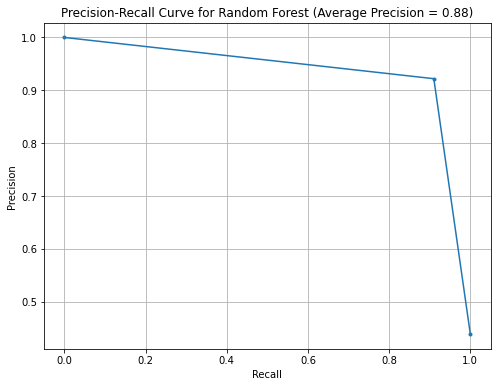

In [79]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score

# Step 1: Define and Train Random Forest Model
rf = RandomForestClassifier(labelCol='satisfaction_index', featuresCol='scaled_features', numTrees=100)

# Train the Random Forest model on the scaled training data
rf_model = rf.fit(df_train_scaled)

# Step 2: Make predictions with the Random Forest model on the test data
rf_predictions = rf_model.transform(df_test_scaled)

# Step 3: Evaluate Random Forest Model
evaluator = BinaryClassificationEvaluator(labelCol='satisfaction_index', metricName='areaUnderROC')
rf_auc = evaluator.evaluate(rf_predictions)

# Display the ROC AUC
print(f"Random Forest ROC AUC: {rf_auc:.4f}")

# Confusion Matrix
y_true_rf = rf_predictions.select("satisfaction_index").collect()
y_pred_rf = rf_predictions.select("prediction").collect()

# Convert to numpy arrays for sklearn
y_true_rf = [row[0] for row in y_true_rf]
y_pred_rf = [row[0] for row in y_pred_rf]

# Calculate confusion matrix
cm_rf = confusion_matrix(y_true_rf, y_pred_rf)

# Display confusion matrix
print("Confusion Matrix for Random Forest:")
print(cm_rf)

# Calculate Precision-Recall Curve
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true_rf, y_pred_rf)
average_precision_rf = average_precision_score(y_true_rf, y_pred_rf)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest (Average Precision = {:.2f})'.format(average_precision_rf))
plt.grid()
plt.show()


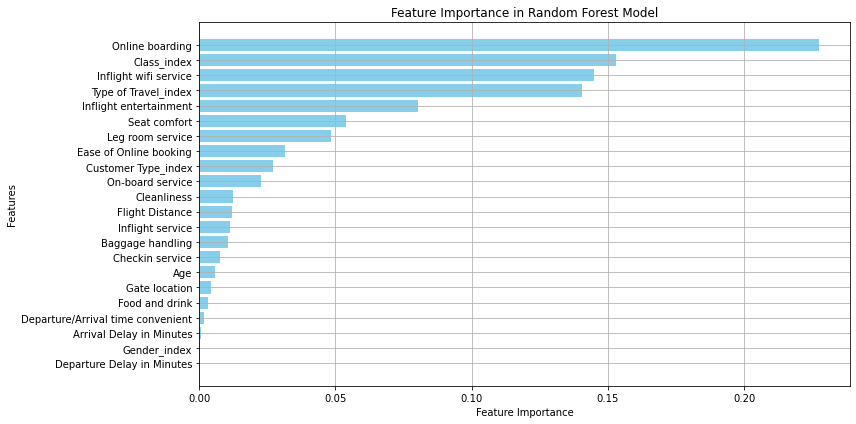

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate Feature Importance
# Get feature importances from the trained Random Forest model
feature_importances = rf_model.featureImportances

# Combine feature names and importance scores into a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,  # feature_cols: list of feature names used in training
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Step 2: Visualize Feature Importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance on top
plt.grid(True)
plt.tight_layout()
plt.show()


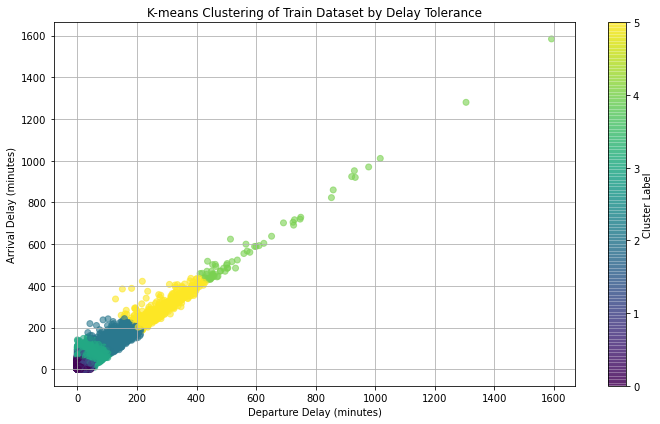

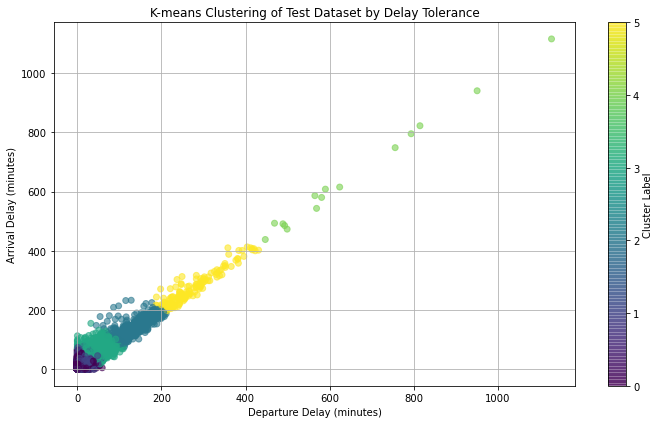

In [82]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
import matplotlib.pyplot as plt

# Step 1: Select features related to delays and satisfaction from train dataset
selected_columns_delays = [
    "Departure Delay in Minutes", 
    "Arrival Delay in Minutes", 
    "satisfaction"
]

# Step 2: Prepare the training dataset
# Select specified columns from the train dataset
df_train_delays = df_train_cleaned.select(*selected_columns_delays)

# Convert 'satisfaction' to numerical in train dataset
indexer_delays = StringIndexer(inputCol="satisfaction", outputCol="satisfaction_index")
df_train_delays = indexer_delays.fit(df_train_delays).transform(df_train_delays)

# Step 3: Assemble the features into a vector (train dataset)
assembler_delays = VectorAssembler(
    inputCols=["Departure Delay in Minutes", "Arrival Delay in Minutes", "satisfaction_index"], 
    outputCol="features"
)

# Apply the assembler to the training dataset
df_train_features_delays = assembler_delays.transform(df_train_delays)

# Step 4: Standardize the features in train dataset
scaler_delays = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model_delays = scaler_delays.fit(df_train_features_delays)

# Apply the scaler to the training dataset
df_train_scaled_delays = scaler_model_delays.transform(df_train_features_delays)

# Step 5: Apply K-means clustering to train dataset 
kmeans = KMeans(featuresCol="scaled_features", k=6, seed=1)
kmeans_model = kmeans.fit(df_train_scaled_delays)

# Make predictions and assign clusters to train dataset
df_train_clusters_delays = kmeans_model.transform(df_train_scaled_delays)

# Step 6: Prepare the test dataset
# Select specified columns from the test dataset
df_test_delays = df_test_cleaned.select(*selected_columns_delays)

# Convert 'satisfaction' to numerical in test dataset using the same indexer
df_test_delays = indexer_delays.fit(df_test_delays).transform(df_test_delays)

# Apply the assembler to the test dataset
df_test_features_delays = assembler_delays.transform(df_test_delays)

# Standardize the features in test dataset using the scaler fitted on the training data
df_test_scaled_delays = scaler_model_delays.transform(df_test_features_delays)

# Make predictions and assign clusters to test dataset
df_test_clusters_delays = kmeans_model.transform(df_test_scaled_delays)

# Step 7: Convert predictions to Pandas DataFrame for visualization
predictions_train_pd = df_train_clusters_delays.select("Departure Delay in Minutes", 
                                                       "Arrival Delay in Minutes", 
                                                       "satisfaction_index", 
                                                       "prediction").toPandas()

predictions_test_pd = df_test_clusters_delays.select("Departure Delay in Minutes", 
                                                     "Arrival Delay in Minutes", 
                                                     "satisfaction_index", 
                                                     "prediction").toPandas()

# Step 8: Visualize clustering results for train dataset
plt.figure(figsize=(10, 6))
plt.scatter(predictions_train_pd["Departure Delay in Minutes"], 
            predictions_train_pd["Arrival Delay in Minutes"], 
            c=predictions_train_pd["prediction"], 
            cmap='viridis', alpha=0.6)

plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.title("K-means Clustering of Train Dataset by Delay Tolerance")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Visualize clustering results for test dataset
plt.figure(figsize=(10, 6))
plt.scatter(predictions_test_pd["Departure Delay in Minutes"], 
            predictions_test_pd["Arrival Delay in Minutes"], 
            c=predictions_test_pd["prediction"], 
            cmap='viridis', alpha=0.6)

plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Arrival Delay (minutes)")
plt.title("K-means Clustering of Test Dataset by Delay Tolerance")
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#